## Data Analysis specific to College BID, San Diego, CA

In [33]:
# Yelp API
#Business Search        URL -- 'https://api.yelp.com/v3/businesses/search'
#Business Match         URL -- 'https://api.yelp.com/v3/businesses/matches'
#Phone Search           URL -- 'https://api.yelp.com/v3/businesses/search/phone'
#Business Details       URL -- 'https://api.yelp.com/v3/businesses/{id}'
#Business Reviews       URL -- 'https://api.yelp.com/v3/businesses/{id}/reviews'

### Initialization

In [10]:
import requests
import folium
import json
from YelpAPI import get_my_key
from folium.plugins import MarkerCluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
API_KEY = get_my_key()
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization': 'bearer %s' % API_KEY}
# Define the parameters
PARAMETERS = {'limit': 50,
              'offset': 0,
              'latitude': 32.762717,
             'longitude': -117.067209,
             'radius': 1500}
# Make a request to Yelp API
response = requests.get(url = ENDPOINT, params= PARAMETERS, headers= HEADERS)
business_data = response.json()

In [36]:
yelpdata = {}
business_data = response.json()
for biz in business_data['businesses']:
    
    ID = biz['id']
    rating = biz['rating']
    name = biz['name']
    coordinates = biz['coordinates']
    yelpdata[ID] = {'rating': rating,
                   'name': name,
                   'coordinates': coordinates}
with open('collegeBID.json', 'w') as f:
    json.dump(yelpdata, f, indent=2)

### Scale Up

In [37]:
API_KEY = get_my_key()
ENDPOINT = 'https://api.yelp.com/v3/businesses/search'
HEADERS = {'Authorization': 'bearer %s' % API_KEY}
    
for i in range(10):
    PARAMETERS = {'limit': 50,
                  'offset': 50 + i * 50,
                  'latitude': 32.762717,
                 'longitude': -117.067209,
                 'radius': 1500}
    response = requests.get(url = ENDPOINT, params= PARAMETERS, headers= HEADERS)
    g = open('collegeBID.json')
    yelpdata = json.load(g)
    business_data = response.json()
    for biz in business_data['businesses']:
        ID = biz['id']
        rating = biz['rating']
        name = biz['name']
        coordinates = biz['coordinates']
        yelpdata[ID] = {'rating': rating,
                       'name': name,
                       'coordinates': coordinates}
    with open('collegeBID.json', 'w') as f:
        json.dump(yelpdata, f, indent=2)

### Location Visualization with Folium

In [38]:
m = folium.Map(location=[32.762717, -117.067209], zoom_start=12, tiles="Stamen Terrain")
folium.Marker(
    location=[32.762717, -117.067209],
    popup='College BID',
    icon=folium.Icon(color='darkpurple'),
    ).add_to(m)
top = folium.FeatureGroup(name='Top Rating', show=False)
m.add_child(top)

API_KEY = get_my_key()
g = open('collegeBID.json')
yelpdata = json.load(g)
id_list = list(yelpdata.keys())
for i in range(len(id_list) -1):
    biz = yelpdata[id_list[i]]
    name = biz['name']
    la = biz['coordinates']['latitude']
    lon = biz['coordinates']['longitude']
    if (la == None or lon == None):
        continue
    rating = biz['rating']
    if rating > 4.7:
        col = 'darkgreen'
    elif rating > 4.2:
        col = 'green'
    elif rating > 3.7:
        col = 'orange'
    elif rating > 3.2:
        col = 'lightred'
    else:
        col = 'red'
    folium.Marker(
    location=[la, lon],
    popup=name,
    icon=folium.Icon(color=col),
    ).add_to(m)
    
m.save("collegeBID.html")

## Cross Match with Business Dataset

In [13]:
import pandas as pd
import numpy as np
import folium
#def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
def fuzMatch(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
            
    Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
    return Ratio

df = pd.read_excel('year.xlsx', dtype="string")
nameSet = df['Business Name']
yearSet = df['Year']
employeeSet = df['Employees']
yearSet = list(map(int, yearSet))
employeeSet = list(map(int, employeeSet))

In [14]:
ratingP = []
yearP = []
employeeP = []
g = open('collegeBID.json')
yelpdata = json.load(g)
id_list = list(yelpdata.keys())
for i in range(len(id_list) -1):
    biz = yelpdata[id_list[i]]
    name = biz['name']
    rating = biz['rating']
    for j in range(len(nameSet) - 1):
        if fuzMatch(nameSet[j], name) > 0.6:
            ratingP.append(rating)
            yearP.append(yearSet[j])
            employeeP.append(employeeSet[j])
            break

with open('ratingP.json', 'w') as f:
    json.dump(ratingP, f, indent=2)
with open('yearP.json', 'w') as f:
    json.dump(yearP, f, indent=2)
with open('employeeP.json', 'w') as f:
    json.dump(employeeP, f, indent=2)

## Rating vs. Years in business

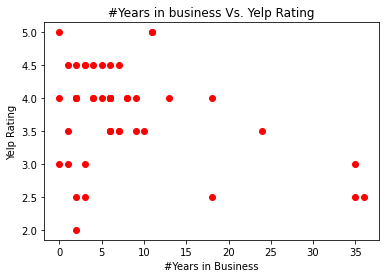

In [15]:
g = open('ratingP.json')
rating = list(json.load(g))
g = open('yearP.json')
yearP = list(json.load(g))

plt.scatter(yearP, ratingP, c='r')
plt.xlabel('#Years in Business')
plt.ylabel('Yelp Rating')
plt.title('#Years in business Vs. Yelp Rating')
plt.show()

## Rating vs. Employee Numbers

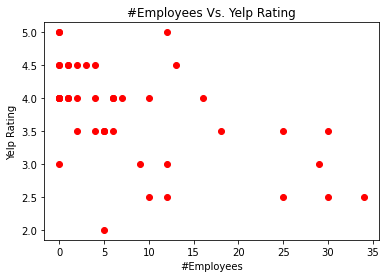

In [17]:
g = open('ratingP.json')
rating = list(json.load(g))
g = open('employeeP.json')
yearP = list(json.load(g))

plt.scatter(employeeP, ratingP, c='r')
plt.xlabel('#Employees')
plt.ylabel('Yelp Rating')
plt.title('#Employees Vs. Yelp Rating')
plt.show()

In [45]:
m = folium.Map(location=[32.762717, -117.067209], zoom_start=12, tiles="Stamen Terrain")
folium.Marker(
    location=[32.762717, -117.067209],
    popup='College BID',
    icon=folium.Icon(color='darkpurple'),
    ).add_to(m)
top = folium.FeatureGroup(name='Top Rating', show=False)
m.add_child(top)


g = open('collegeBID.json')
yelpdata = json.load(g)
id_list = list(yelpdata.keys())
for i in range(len(id_list) -1):
    biz = yelpdata[id_list[i]]
    name = biz['name']
    la = biz['coordinates']['latitude']
    lon = biz['coordinates']['longitude']
    counter = 0
    for entry in nameSet:
        if fuzMatch(entry, name) > 0.6:
            counter += 1
    if counter > 0:
        col = 'green'
    else:
        col = 'gray'
        
    folium.Marker(
    location=[la, lon],
    popup=name,
    icon=folium.Icon(color=col),
    ).add_to(m)
    
m.save("collegeMatch.html")

In [43]:
# 0.6 is the magic number
g = open('collegeBID.json')
yelpdata = json.load(g)
id_list = list(yelpdata.keys())
biz = yelpdata[id_list[34]]
name = biz['name']
counter = 0
for entry in nameSet:
    ratio = fuzMatch(entry, name)
    if ratio > 0.6:
        counter += 1
print(counter)

0
